# Assignment 2

**Submission deadline: last lab session before or on Thursday, 26.03.2020**

**Points: 6 + 1 bonus points**

## Submission instructions
The class is held remotely. To sumbmit your solutions please save the notebook to your Google Drive, then:
1. Rename it it to: Assignment2_Surname_FirstName
2. Rerun the whole notebook `Runtime -> Restar and run all`
3. Make a pinned revision `File->Save and pin revision`
4. Share the notebook with your instructor using his `cs.uni.wroc.pl` email

We will use the commenting system and video conferences to check and discuss the solutions.

As always, please submit corrections using GitHub's Pull Requests.

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

The code below contains a mock-up of a two-layer neural network. Fill in the code and manually set weights to solve the XOR problem.

Please note: the shapes are set to be compatible with PyTorch's conventions:
* a batch containing $N$ $D$-dimensional examples has shape $N\times D$ (each example is a row!)
* a weight matrix in a linear layer with $I$ inputs and $O$ outputs has shape $O \times I$
* a bias vector is a 1D vector. Please note that [broadcasting rules](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) allow us to think about it as a $1 \times D` matrix.

Text(0, 0.5, 'X[1]')

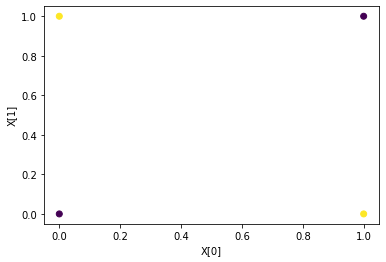

In [ ]:
# Let's define a XOR dataset

# X will be matrix of N 2-dimensional inputs
X = np.array(
    [[0, 0],
     [0, 1],
     [1, 0],
     [1, 1],
    ], dtype=np.float32)
# Y is a matrix of N numners - answers
Y = np.array(
    [[0],
     [1],
     [1],
     [0],
    ], dtype=np.float32)

plt.scatter(X[:,0], X[:,1], c=Y[:,0], )
plt.xlabel('X[0]')
plt.ylabel('X[1]')

# Problem 1 [2p]

Fill in the details of a forward pass, then manually set the weights and biases in the network to solve the 2D XOR task defined above.

In [ ]:
def safe_log(x):
    return np.log(x+1e-100)

In [ ]:
def sigmoid(x):
    return 1/(1+np.e**-x)

def relu(x):
    return (x > 0) * x 

class SmallNet:
    def __init__(self, in_features, num_hidden, dtype=np.float32, relu = False):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.init_params()
        self.relu = relu

    def init_params(self):
        # TODO Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        self.W1 = 0.7*np.random.randn(*self.W1.shape).astype(self.W1.dtype)
        self.b1 = 0.7*np.random.randn(*self.b1.shape).astype(self.b1.dtype)
        self.W2 = 0.7*np.random.randn(*self.W2.shape).astype(self.W2.dtype)
        self.b2 = 0.7*np.random.randn(*self.b2.shape).astype(self.b2.dtype)


    def forward(self, X, Y=None, do_backward=False):
        # TODO Problem 1: Fill in details of forward propagation

        # Input to neurons in 1st layer
        A1 = X @ self.W1.T + self.b1
        # Outputs after the sigmoid non-linearity
        if self.relu:
            O1 = relu(A1)
        else:
            O1 = sigmoid(A1)
        # Inputs to neuron in the second layer
        A2 = O1 @ self.W2.T + self.b2
        # Outputs after the sigmoid non-linearity
        O2 = sigmoid(A2)

        if Y is not None:
            # cross entropy loss
            loss = - Y*safe_log(O2) - (1-Y)*safe_log(1-O2)
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            # TODO in Problem 2: fill in the gradient computation
            # Please note, thate there is a correspondance between
            # the forward and backward pass: with backward computations happening
            # in reversed order. 

            # A2_grad is the gradient of loss with respect to A2
            # Hint: there is a concise formula for the gradient 
            # of logistic sigmoid and cross-entropy loss 
            batch_size = X.shape[0]
            O2_grad = - Y / (O2 + 1e-100) + (1-Y)/(1-O2+1e-100)
            A2_grad = O2_grad * sigmoid(A2) * (1- sigmoid(A2)) / batch_size
            self.b2_grad = A2_grad.sum(0)
            self.W2_grad = A2_grad.T @ O1
            O1_grad = A2_grad * self.W2
            if self.relu:
                A1_grad = O1_grad * ((A1 > 0) * 1.)
            else: 
                A1_grad = O1_grad * sigmoid(A1) * (1- sigmoid(A1))
            self.b1_grad = A1_grad.sum(0)
            self.W1_grad = A1_grad.T @ X
        return O2, loss

In [ ]:
# TODO Problem 1:
# Set by hand the weight values to solve the XOR problem

net = SmallNet(2, 2, dtype=np.float64)
net.W1 = np.array([[10.,10.],[10.,10.]])
net.b1 = np.array([-5.,-15.])
net.W2 = np.array([[10.,-10.]])
net.b2 = np.array([-5.])

# Hint: since we use the logistic sigmoid activation, the weights may need to 
# be fairly large 


net.forward(X, Y, do_backward=False)

(array([[0.00715279],
        [0.99235586],
        [0.99235586],
        [0.00715279]]), 0.0074259970019481605)

# Problem 2 [2p]

1. Fill in the backward pass.
2. Implement random initialization of network parameters.
3. Using `float64` verify correctness of your backward pass.

In [ ]:
def check_grad(net, param_name, X, Y, eps=1e-5):
    """A gradient checking routine"""

    param = getattr(net, param_name)
    param_flat_accessor = param.reshape(-1)

    grad = np.empty_like(param)
    grad_flat_accessor = grad.reshape(-1)

    net.forward(X, Y, do_backward=True)
    orig_grad = getattr(net, param_name + '_grad')
    assert (param.shape == orig_grad.shape)

    for i in range(param_flat_accessor.shape[0]):
        orig_val = param_flat_accessor[i]
        param_flat_accessor[i] = orig_val + eps
        _, loss_positive = net.forward(X, Y)
        param_flat_accessor[i] = orig_val - eps
        _, loss_negative = net.forward(X, Y)
        param_flat_accessor[i] = orig_val
        grad_flat_accessor[i] = (
            loss_positive - loss_negative) / (2 * eps)
    assert np.allclose(grad, orig_grad)
    return grad, orig_grad

In [ ]:
net = SmallNet(2, 2, dtype=np.float64)

for param_name in ['b2', 'W2', 'b1', 'W1']:
    check_grad(net, param_name, X, Y)

# Problem 3 [2p]

Fill in the details of batch gradient descent below, then train a network to solve 2D XOR problem.

Then test the reliability of solving the 3D XOR task.

In [ ]:
net = SmallNet(2, 10, dtype=np.float64)

alpha = 1e-1

for i in range(100000):
    _, loss = net.forward(X, Y, do_backward=True)
    if (i % 5000) == 0:
        print(i, loss)
    for param_name in ['W1', 'b1', 'W2', 'b2']:
        param = getattr(net, param_name)
        # Hint: use the construct `param[:]` to change the contents of the array!
        # Doing instead `param = new_val` simply changes to what the variable
        # param points to, without affecting the network!
        grad = getattr(net, param_name + '_grad')
        param[:] = param - alpha*grad

0 0.8342256490132501
5000 0.02250542948111045
10000 0.008472332593986704
15000 0.00504752827780425
20000 0.003544380671431236
25000 0.0027096735030427413
30000 0.0021821624069879608
35000 0.0018201995635821178
40000 0.0015572366676195957
45000 0.0013580027780514974
50000 0.0012021125933069723
55000 0.0010769871618859293
60000 0.000974455977474877
65000 0.0008889880624476422
70000 0.0008167096327934218
75000 0.0007548290536139583
80000 0.0007012851197738451
85000 0.000654523795670097
90000 0.0006133519128584896
95000 0.0005768386138240926


In [ ]:
net.forward(X, Y, do_backward=True)

(array([[2.95002322e-04],
        [9.99541506e-01],
        [9.99344509e-01],
        [7.67343731e-04]]), 0.0005442473341863997)

Generate below data for a 3D XOR task. Try a few values of hidden layer size. Plot the reliability of training, i.e. how many trainings succeed for a given hiden layer size.

What is easier to train: a smaller, or large network?

In [ ]:
def train(net, X, Y, iterations, alpha = 1e-1):
    for i in range(iterations):
        _, loss = net.forward(X, Y, do_backward=True)
        for param_name in ['W1', 'b1', 'W2', 'b2']:
            param = getattr(net, param_name)
            grad = getattr(net, param_name + '_grad')
            param[:] = param - alpha*grad
    return loss

In [ ]:
# X3 will be matrix of N 3-dimensional inputs
X3 = np.array(
    [[0, 0, 0],
     [0, 0, 1],
     [0, 1, 0],
     [0, 1, 1],
     [1, 0, 0],
     [1, 0, 1],
     [1, 1, 0],
     [1, 1, 1],
    ], dtype=np.float32)
# Y is a matrix of N numners - answers
Y3 = np.array(
    [[0],
     [1],
     [1],
     [0],
     [1],
     [0],
     [0],
     [1],
    ], dtype=np.float32)

num_of_trains = 100
succss = []
mean_loss = []
min_loss = []
for hidden_dim in [2, 3, 5, 10, 20]:
    succ = 0
    losss = []
    for _ in range(num_of_trains):
        net = SmallNet(3, hidden_dim, dtype=np.float32)
        loss = train(net,X3,Y3,10000)
        succ += loss < 0.05
        losss.append(loss)
    print(f'Number of hidden dim: {hidden_dim}, Succeeded training rate: {succ/num_of_trains}')
    succss.append(succ/num_of_trains)
    mean_loss.append(np.mean(np.array(losss)))
    min_loss.append(min(losss))

Number of hidden dim: 2, Succeeded training rate: 0.0
Number of hidden dim: 3, Succeeded training rate: 0.22
Number of hidden dim: 5, Succeeded training rate: 0.54
Number of hidden dim: 10, Succeeded training rate: 0.94
Number of hidden dim: 20, Succeeded training rate: 1.0


Text(0.5, 1.0, 'Training difficulty with the different hidden dim size')

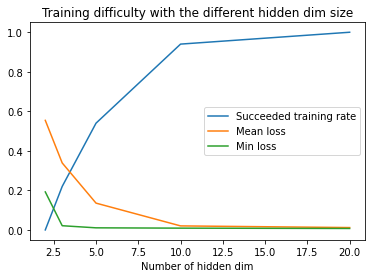

In [ ]:
plt.plot([2, 3, 5, 10, 20],succss,label='Succeeded training rate')
plt.plot([2, 3, 5, 10, 20],mean_loss,label='Mean loss')
plt.plot([2, 3, 5, 10, 20],min_loss,label='Min loss')
plt.legend()
plt.xlabel('Number of hidden dim')
plt.title('Training difficulty with the different hidden dim size')

In this example it was easier to train a large network than a small one. 

# Problem 4 [1bp]

Replace the first nonlinearity with the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function. Verify ho

In [ ]:
succss2 = []
mean_loss2 = []
min_loss2 = []
for hidden_dim in [2, 3, 5, 10, 20]:
    succ = 0
    losss = []
    for _ in range(num_of_trains):
        net = SmallNet(3, hidden_dim, dtype=np.float32, relu = True)
        loss = train(net,X3,Y3,10000)
        succ += loss < 0.05
        losss.append(loss)
    print(f'Number of hidden dim: {hidden_dim}, Succeeded training rate: {succ/num_of_trains}')
    succss2.append(succ/num_of_trains)
    mean_loss2.append(np.mean(np.array(losss)))
    min_loss2.append(min(losss))

Number of hidden dim: 2, Succeeded training rate: 0.0
Number of hidden dim: 3, Succeeded training rate: 0.08
Number of hidden dim: 5, Succeeded training rate: 0.48
Number of hidden dim: 10, Succeeded training rate: 0.89
Number of hidden dim: 20, Succeeded training rate: 1.0


Text(0.5, 1.0, 'Training difficulty with the different hidden dim size')

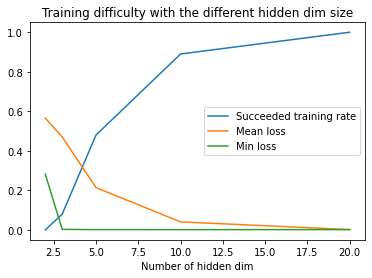

In [ ]:
plt.plot([2, 3, 5, 10, 20],succss2,label='Succeeded training rate')
plt.plot([2, 3, 5, 10, 20],mean_loss2,label='Mean loss')
plt.plot([2, 3, 5, 10, 20],min_loss2,label='Min loss')
plt.legend()
plt.xlabel('Number of hidden dim')
plt.title('Training difficulty with the different hidden dim size')

Text(0.5, 1.0, 'Relu vs Sigmoid')

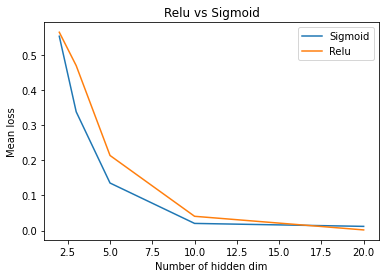

In [ ]:
plt.plot([2, 3, 5, 10, 20],mean_loss,label='Sigmoid')
plt.plot([2, 3, 5, 10, 20],mean_loss2,label='Relu')
plt.legend()
plt.xlabel('Number of hidden dim')
plt.ylabel('Mean loss')
plt.title('Relu vs Sigmoid')

In [ ]:
net = SmallNet(2, 10, dtype=np.float64)
netR = SmallNet(2, 10, dtype=np.float64, relu = True)

alpha = 1e-1

for i in range(100000):
    _, loss = net.forward(X, Y, do_backward=True)
    _, lossR = netR.forward(X, Y, do_backward=True)
    if (i % 5000) == 0:
        print(f'Iteration: {i}, sigmoid net loss: {loss}, relu net loss: {lossR}')
    for param_name in ['W1', 'b1', 'W2', 'b2']:
        param = getattr(net, param_name)
        paramR = getattr(netR, param_name)
        # Hint: use the construct `param[:]` to change the contents of the array!
        # Doing instead `param = new_val` simply changes to what the variable
        # param points to, without affecting the network!
        grad = getattr(net, param_name + '_grad')
        gradR = getattr(netR, param_name + '_grad')
        param[:] = param - alpha*grad
        paramR[:] = paramR - alpha*gradR

Iteration: 0, sigmoid net loss: 0.7335706733966958, relu net loss: 1.0738448831457759
Iteration: 5000, sigmoid net loss: 0.04688074848088769, relu net loss: 0.0012779638698742902
Iteration: 10000, sigmoid net loss: 0.01285655035199927, relu net loss: 0.0005513584099417952
Iteration: 15000, sigmoid net loss: 0.007078521846666628, relu net loss: 0.0003406127763972655
Iteration: 20000, sigmoid net loss: 0.00479631686464316, relu net loss: 0.00024291304427585768
Iteration: 25000, sigmoid net loss: 0.0035922018586110665, relu net loss: 0.00018725426122386375
Iteration: 30000, sigmoid net loss: 0.002853968215245831, relu net loss: 0.00015155827070478
Iteration: 35000, sigmoid net loss: 0.0023575074623438086, relu net loss: 0.0001268354285173268
Iteration: 40000, sigmoid net loss: 0.0020019878133962624, relu net loss: 0.00010876285652062714
Iteration: 45000, sigmoid net loss: 0.0017355397343008264, relu net loss: 9.500803685224433e-05
Iteration: 50000, sigmoid net loss: 0.0015288326870612785,

As we can see for different hidden dim size and 10000 training iterations nets with a relu function and sigmoid function works almost the same, but if we consider more training iterations, then relu functions get much better scores. 